## Backpropagation Exercise
In this exercise we will use backpropagation to train a multi-layer perceptron (with a single hidden layer).  We will experiment with different patterns and see how quickly or slowly the weights converge.  We will see the impact and interplay of different parameters such as learning rate, number of iterations, and number of data points.

In [43]:
#Preliminaries
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Complete the code below to create a multi-layer perceptron with a single hidden layer (4 nodes) and trains it via back-propagation. The code should:

1. Initialize the weights to random values between -1 and 1
1. Perform the feed-forward computation
1. Compute the loss function
1. Calculate the gradients for all the weights via back-propagation
1. Update the weight matrices (using a learning_rate parameter)
1. Execute steps 2-5 for a fixed number of iterations
1. Plot the accuracies and log loss and observe how they change over the iterations


Once the code is running, try it for the different patterns.

- Which patterns was the neural network able to learn quickly and which took longer?
- What learning rates and numbers of iterations worked well?
- Optional: vary the size of the hidden layer and experiment with different activation functions (e.g. ReLu)

shape of X is (1000, 3)
shape of y is (1000, 1)


(-1.0997754533409827,
 1.0988875751620137,
 -1.0997122119543052,
 1.099240916555307)

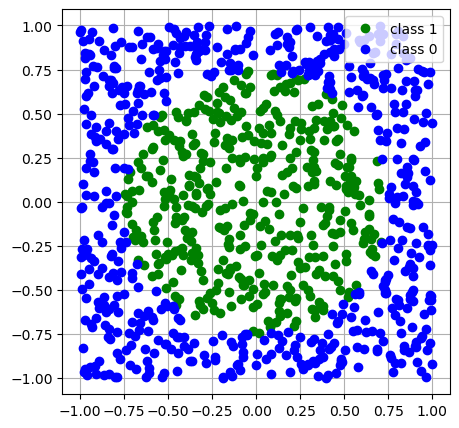

In [44]:
# The code below generates x, y values according to different patterns and "bias" term (a vector of 1's)
# The goal is then to learn the mapping from x to y using a neural network via back-propagation

num_obs = 1000
data = np.random.uniform(-1, 1, size=(num_obs, 2))
bias = np.ones((num_obs, 1))
X = np.concatenate((data, bias), axis=1)

patterns = {
    'circle': lambda X: (np.sqrt(X[:, 0]**2 + X[:, 1]**2) < 0.75).astype(int).reshape(num_obs, 1),
    'diamond': lambda X: ((np.abs(X[:, 0]) + np.abs(X[:, 1])) < 1).astype(int).reshape(num_obs, 1),
    'square': lambda X: ((np.maximum(np.abs(X[:, 0]), np.abs(X[:, 1]))) < 0.75).astype(int).reshape(num_obs, 1),
    'angle': lambda X: (((np.maximum((X[:, 0]), (X[:, 1]))) < 0.5) & ((np.maximum((X[:, 0]), (X[:, 1]))) > -0.5)).astype(int).reshape(num_obs, 1),
    'angle_thin': lambda X: (((np.maximum((X[:, 0]), (X[:, 1]))) < 0.5) & ((np.maximum((X[:, 0]), (X[:, 1]))) > 0.0)).astype(int).reshape(num_obs, 1)
}

# Start with circle and CHANGE AND OTHER TRY PATTERN AFTER COMPLETING
y = patterns['circle'](X)

print(f'shape of X is {X.shape}')
print(f'shape of y is {y.shape}')

class1 = (y == 1).reshape(num_obs)
class0 = (y == 0).reshape(num_obs)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(X[class1, 0], X[class1, 1], 'o', label='class 1', color='green')
ax.plot(X[class0, 0], X[class0, 1], 'o', label='class 0', color='blue')
ax.grid(True)
ax.legend(loc='best')
ax.axis('equal')

Here are some helper functions

In [45]:
# Sigmoid function
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

Write the function `sigmoid_derivative`.

In [46]:
### code start
def sigmoid_derivative(x):
    return sigmoid(x)*(1-sigmoid(x))
### code end

sigmoid_derivative(np.array([-8.0, 0.0 , 8.0]))

array([0.00033524, 0.25      , 0.00033524])

expected output:
```
array([0.00033524, 0.25      , 0.00033524])
```

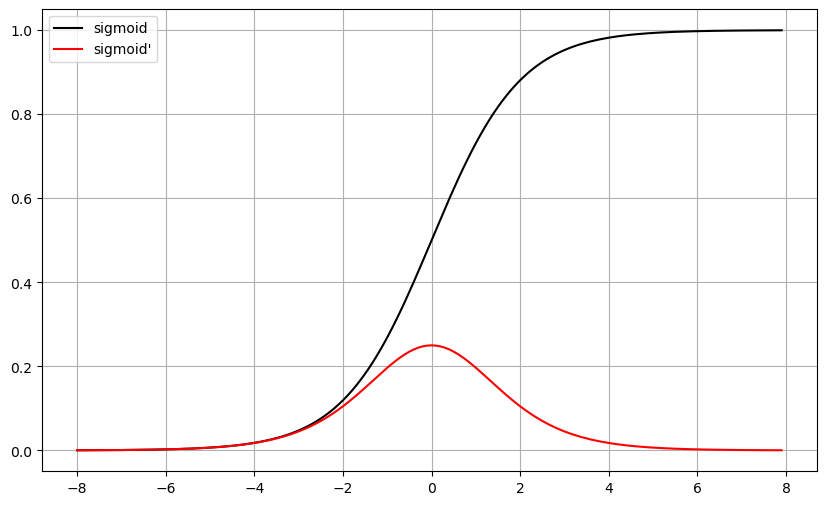

In [47]:
d = np.arange(-8,8,0.1)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(d, sigmoid(d), '-', label='sigmoid', color='black')
ax.plot(d, sigmoid_derivative(d), '-', label='sigmoid\'', color='red')
ax.grid(True)
ax.legend(loc='best');

In [48]:
# Loss function we would like to optimize (minimize)
# The Log Loss (or cross entropy loss) is used here
def logLoss(y, y_pred, eps=1e-16):
    y_pred = np.minimum(np.maximum(y_pred, eps), (1-eps))
    return -np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

In [49]:
def plot_loss_acc(loss, acc):
    fig = plt.figure(figsize=(16, 8))
    fig.suptitle('Log Loss and Accuracy over iterations')

    ax = fig.add_subplot(1, 2, 1)
    ax.plot(loss)
    ax.grid(True)
    ax.set(xlabel='iterations', title='Log Loss')

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(acc)
    ax.grid(True)
    ax.set(xlabel='iterations', title='Accuracy')

Calculate the gradients

| Math | Code | Description |
| :--- | :--- | :---------- |
| $\partial L^{(3)}= (\hat{y} - y)$ | `d_L3 = (y_pred - y)` | The derivative of the loss wrt output (prediction) |
| $\partial a^{(3)}= \sigma'(z^{(3)})$ | `d_a3 = sigmoid_derivative(z3)` | The derivative of sigmoid  wrt the input (before activation) of the output layer |
| $\partial z^{(3)}= a^{(2)}$ | `d_z3 = a2` | The derivative of the inputs of the hidden layer (before activation) wrt weights of the output layer |
| $\partial L^{(2)}=\left ( \partial a^{(3)} \partial L^{(3)} \right ) \cdot W^{(2)^T}$ | `d_L2 = np.dot(d_a3 * d_L3, W2.T)` | The derivative of loss wrt hidden layer input (after activation) |
| $\partial a^{(2)} = \sigma'(z^{(2)})$ | `d_a2 = sigmoid_derivative(z2)` | The derivative of sigmoid wrt the inputs of the hidden layer (before activtivation) |
| $\partial z^{(2)}=a^{(1)}$ or $\partial z^{(2)}=X$ | `d_z2 = a1` or `d_z2 = X` | The derivative of the inputs of the hidden layer (before activation) wrt weights of the hidden layer |
| $\frac {\partial J} {\partial W^{(2)}}= \partial z^{(3)^T} \cdot \left ( \partial L^{(3)} \partial a^{(3)} \right )$ | `gradient_W2 = np.dot(d_z3.T, d_L3 * d_a3)` | The gradient applying the chain rule |
| $\frac {\partial J} {\partial W^{(1)}} = \partial z^{(2)^T} \cdot \left ( \partial L^{(2)} \partial a^{(2)} \right )$ | `gradient_W1 = np.dot(d_z2.T, d_L2 * d_a2)` |  |

or

$\frac {\partial J} {\partial W^{(2)}} = a^{(2)^T} \cdot \left ( \left ( \hat{y} - y \right )  \sigma'(z^{(3)}) \right )$

$\frac {\partial J} {\partial W^{(1)}} = a^{(1)^T} \cdot \left ( \sigma' (z^{(3)}) \left ( \hat{y} - y \right ) \cdot W^{(2)^T} \right ) \sigma'(z^{(2)})$

In [50]:
def learnStep(W1, W2, X, y):
    a1 = X

    # the dot product of the weights of the hidden layer and the inputs
    z2 = np.dot(a1, W1)
    # apply sigmoid activation function
    a2 = sigmoid(z2)

    # the same steps for predicted output
    z3 = np.dot(a2, W2)
    a3 = sigmoid(z3)

    # prediction is output of last layer
    y_pred = a3

    ### code start
    # calculate the derivatives
    d_L3 = (y_pred - y)
    d_a3 = sigmoid_derivative(z3)
    d_z3 = a2

    d_L2 = np.dot(d_a3 * d_L3, W2.T)
    d_a2 = sigmoid_derivative(z2)
    d_z2 = a1
    ### code end

    # calculating the gradient using the chain rule
    gradient_W1 = np.dot(d_z2.T, d_L2 * d_a2)
    gradient_W2 = np.dot(d_z3.T, d_L3 * d_a3)

    # without all small (sub)steps
    ### code start
    # gradient_W2 = np.dot(a2.T, (y_pred - y) * sigmoid_derivative(z3))
    # gradient_W1 = np.dot(a1.T, np.dot(sigmoid_derivative(z3) * (y_pred - y), W2.T) * sigmoid_derivative(z2))
    ### code end
    return y_pred, (gradient_W1, gradient_W2)

Test the `learnStep` function

In [51]:
Xt = np.array([[0, 0, 1],
              [0, 1, 1],
              [1, 0, 1],
              [0, 1, 0],
              [1, 0, 0],
              [1, 1, 1],
              [0, 0, 0]])

yt = np.array([[0, 1, 1, 1, 1, 0, 0]]).T

W1t = np.array([[-4.31963300e-01, -7.67176941e-01],
                [3.45712517e-01, -2.83834014e-04],
                [-4.02387050e-01,  6.04423225e-01]])

W2t = np.array([[0.09223889],
                [-0.79653626]])

yp, (g1, g2) = learnStep(W1t, W2t, Xt, yt)

print(yp)
print(g1)
print(g2)

[[0.38269368]
 [0.38456189]
 [0.41629379]
 [0.41478995]
 [0.44614393]
 [0.41804526]
 [0.41286147]]
[[-0.00356406  0.03154556]
 [-0.00432525  0.03468097]
 [-0.00190446  0.01799751]]
[[-0.12582278]
 [-0.11853657]]


Expected output:
```
[[0.38269368]
 [0.38456189]
 [0.41629379]
 [0.41478995]
 [0.44614393]
 [0.41804526]
 [0.41286147]]
[[-0.00356406  0.03154556]
 [-0.00432525  0.03468097]
 [-0.00190446  0.01799751]]
[[-0.12582278]
 [-0.11853657]]
 ```

In [52]:
def train(X, y, learning_rate=0.05, num_iter=1000):
# Initialize the network parameters
    np.random.seed(123)
    W_1 = np.random.uniform(-1, 1, size=(3, 4))
    W_2 = np.random.uniform(-1, 1, size=(4, 1))

    losses, accuracies = [], []
    for i in range(num_iter):
        ### code start
        # Do a forward computation, and get the prediction an gradient

        y_hat, (W1_grad, W2_grad) = learnStep(W_1, W_2, X, y)
        ### code end

        ### code start
        # Update weights
        W_1 -= (learning_rate * W1_grad)
        W_2 -= (learning_rate * W2_grad)
        ### code end

        # Compute loss and accuracy
        L = logLoss(y, y_hat)
        losses.append(L)
        accuracies.append(1-L)

        # Print the loss and accuracy for every 500th iteration
        if i % 500 == 0:
            print(f"Loss: {losses[-1]}, Accuracy: {accuracies[-1]}, Iteration: {i}")

    return y_hat, (losses, accuracies)

Loss: 0.6814958188249223, Accuracy: 0.3185041811750777, Iteration: 0
Loss: 0.14413314576360098, Accuracy: 0.855866854236399, Iteration: 500


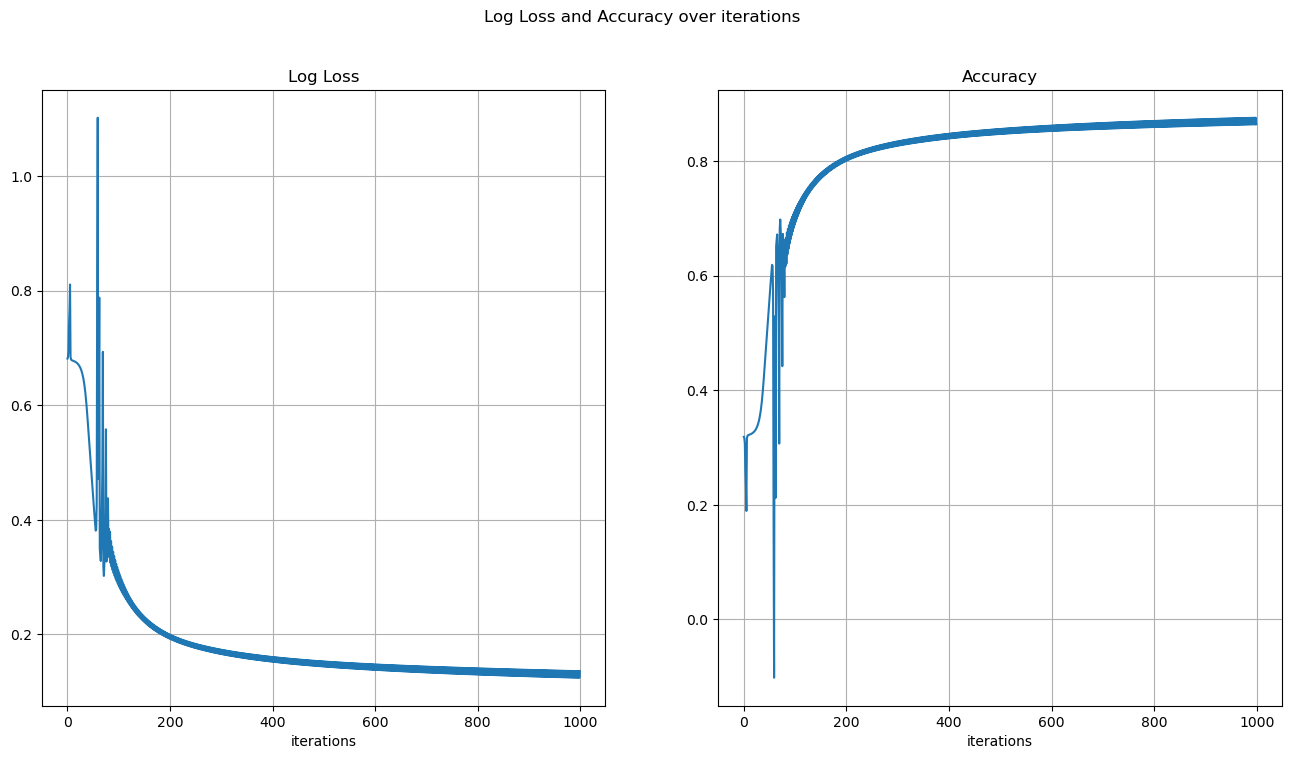

In [53]:
params = {'learning_rate': 0.05, 'num_iter': 1000}

y_pred, (loss, acc) = train(X, y,**params)
plot_loss_acc(loss, acc)

Expected output:
```
Loss: 0.6814958188249223, Accuracy: 0.3185041811750777, Iteration: 0
Loss: 0.1441331457666026, Accuracy: 0.8558668542333974, Iteration: 500
```
<img src='../images/loss_acc_1.png' width='40%'/>

You see the result (loss and accuracy) are not a straigt line. Now, plot the predicted answers with mistakes in red

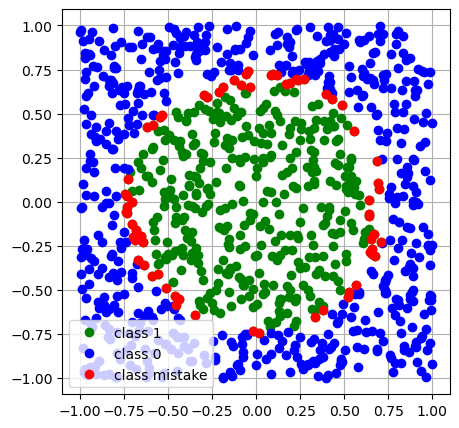

In [54]:
mistakes = (y != (y_pred > .5)).reshape(num_obs)

### code start
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(X[class1, 0],   X[class1, 1],   'o', label='class 1', color='green')
ax.plot(X[class0, 0],   X[class0, 1],   'o', label='class 0', color='blue')
ax.plot(X[mistakes, 0], X[mistakes, 1], 'o', label='class mistake', color='red')
ax.grid(True)
ax.legend(loc='best')
ax.axis('equal')
plt.show()
### code end

expected output:
<img src='../images/mistakes_0.png' width='20%'/>

Retrain the model using different parameters to improve the learning by adjusting learning_rate and iterations. And plot the prediction as above (mistakes in red)

Loss: 0.6814958188249223, Accuracy: 0.3185041811750777, Iteration: 0
Loss: 0.4947253470223089, Accuracy: 0.505274652977691, Iteration: 500
Loss: 0.21294056488309115, Accuracy: 0.7870594351169089, Iteration: 1000
Loss: 0.16329468290935514, Accuracy: 0.8367053170906449, Iteration: 1500
Loss: 0.13919221348656946, Accuracy: 0.8608077865134305, Iteration: 2000
Loss: 0.12416257157321053, Accuracy: 0.8758374284267895, Iteration: 2500
Loss: 0.11363198991718497, Accuracy: 0.8863680100828151, Iteration: 3000
Loss: 0.10578534730663061, Accuracy: 0.8942146526933694, Iteration: 3500
Loss: 0.09969534598054323, Accuracy: 0.9003046540194568, Iteration: 4000
Loss: 0.09481690547276696, Accuracy: 0.905183094527233, Iteration: 4500
Loss: 0.090804866080682, Accuracy: 0.909195133919318, Iteration: 5000
Loss: 0.08743099339756043, Accuracy: 0.9125690066024396, Iteration: 5500
Loss: 0.0845396156283293, Accuracy: 0.9154603843716707, Iteration: 6000
Loss: 0.0820217263494571, Accuracy: 0.9179782736505429, Iterati

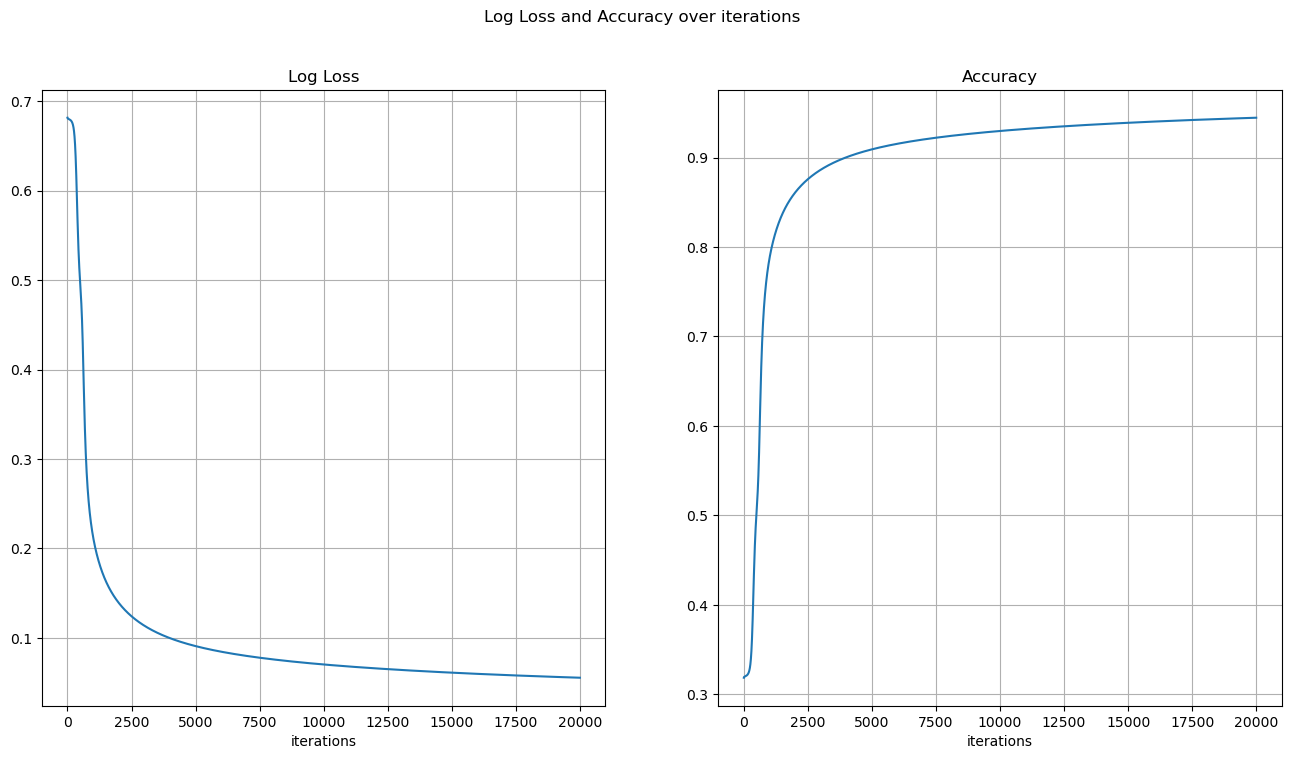

In [55]:
### code start
params = {'learning_rate': 0.005, 'num_iter': 20000}
### code end

y_pred, (loss, acc) = train(X, y, **params)
plot_loss_acc(loss, acc)

Expected (similar) output:

<img src='../images/loss_acc_2.png' width='50%' />

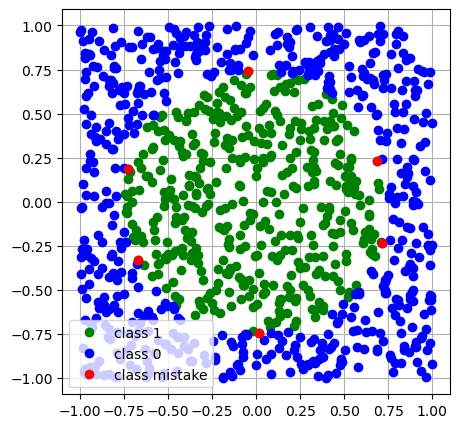

In [56]:
mistakes = (y != (y_pred > .5)).reshape(num_obs)

### code start
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(X[class1, 0],   X[class1, 1],   'o', label='class 1', color='green')
ax.plot(X[class0, 0],   X[class0, 1],   'o', label='class 0', color='blue')
ax.plot(X[mistakes, 0], X[mistakes, 1], 'o', label='class mistake', color='red')
ax.grid(True)
ax.legend(loc='best')
ax.axis('equal')
plt.show()
### code end

expected (similar) output:
<img src='../images/mistakes_1.png' width='20%'/>